In [74]:
import math
import numpy as np 
import pandas as pd 
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout, Conv1D, Lambda, SimpleRNN
import matplotlib.pyplot as plt 
import pandas_datareader as web
plt.style.use('fivethirtyeight')

In [75]:
from os.path import dirname
dirPath = dirname(dirname(os.getcwd()))+"\TotalCleanedTest.csv"
dirPath
df = pd.read_csv(dirPath)
df['ent_regis'] = df['ent_regis'].apply(lambda x: '{0:0>2}'.format(x))
df['ent_resid'] = df['ent_resid'].apply(lambda x: '{0:0>2}'.format(x))
df['ent_ocurr'] = df['ent_ocurr'].apply(lambda x: '{0:0>2}'.format(x))
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'])
df.head()

,ent_regis,ent_regis_nm,mun_regis,mun_regis_nm,ent_resid,ent_resid_nm,mun_resid,mun_resid_nm,ent_ocurr,ent_ocurr_nm,...,complicaro,lengua,ICD,detailCaus,Organ,ICD_Mex,detailCaus_Mex,organ_Mex,date_ocurr,month_year_ocurr
0,01,Aguascalientes,1005,Jesus Maria,01,Aguascalientes,1005,Jesus Maria,01,Aguascalientes,...,8,9,C34,"Tumor maligno de los bronquios o del pulmón, p...",Lungs,C34,"Tumor maligno de la tráquea, de los bronquios ...",Lungs,2012-03-06,2012-03-01
1,01,Aguascalientes,1011,San Francisco de los Romo,01,Aguascalientes,1011,San Francisco de los Romo,01,Aguascalientes,...,8,9,C71,"Tumor maligno del encéfalo, parte no especificada",Brain,C71,Tumor maligno del encéfalo,Brain,2012-02-25,2012-02-01
2,01,Aguascalientes,1003,Calvillo,01,Aguascalientes,1001,Aguascalientes,01,Aguascalientes,...,8,9,C67,"Tumor maligno de la vejiga urinaria, parte no ...",Bladder,C67,Tumor maligno de la vejiga urinaria,Bladder,2012-04-28,2012-04-01
3,01,Aguascalientes,1001,Aguascalientes,01,Aguascalientes,1001,Aguascalientes,01,Aguascalientes,...,8,9,C56,Tumor maligno del ovario,Ovary,C56,Tumor maligno del ovario,Ovary,2012-07-26,2012-07-01
4,01,Aguascalientes,1001,Aguascalientes,01,Aguascalientes,1001,Aguascalientes,01,Aguascalientes,...,8,9,C25,"Tumor maligno del páncreas, parte no especificada",Pancreas,C25,Tumor maligno del páncreas,Pancreas,2012-01-11,2012-01-01


In [76]:
def getTimeSeries(state):
    dff = df.loc[(df['ent_regis'] == state)]
    series = dff['month_year_ocurr'].value_counts().rename_axis('unique_values').reset_index(name='counts')
    series = series.sort_values(by=['unique_values'])
    series.reset_index(inplace=True)
    series = series.drop(columns=['index'])
    return series

In [77]:
series = getTimeSeries('09')
series.head()

,unique_values,counts
0,2012-01-01,884
1,2012-02-01,788
2,2012-03-01,777
3,2012-04-01,756
4,2012-05-01,825


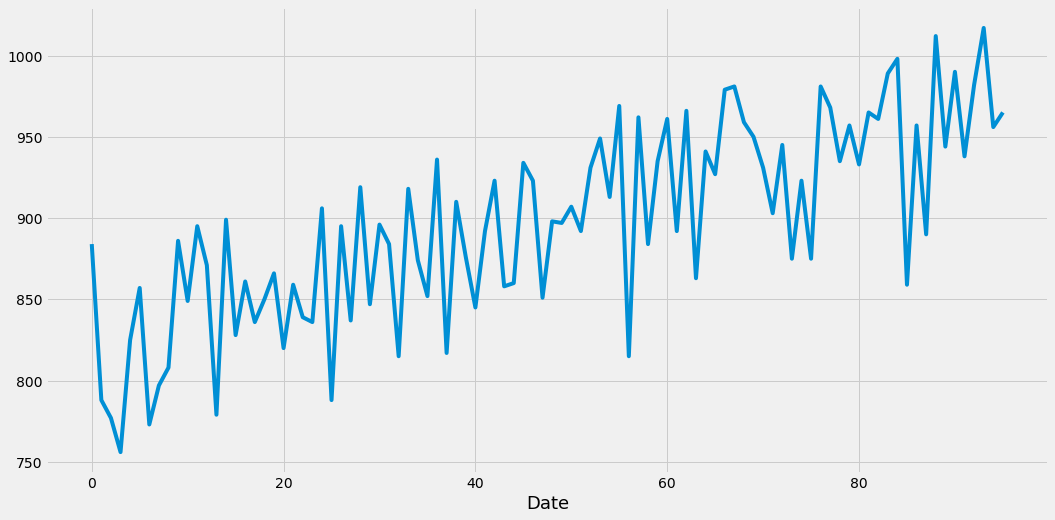

In [78]:
plt.figure(figsize=(16,8))
plt.plot(series['counts'])
plt.xlabel('Date',fontsize=18)
plt.show()

In [80]:
data = series.filter(['counts'])
dataset = data.values
dataset = dataset.astype('float32')

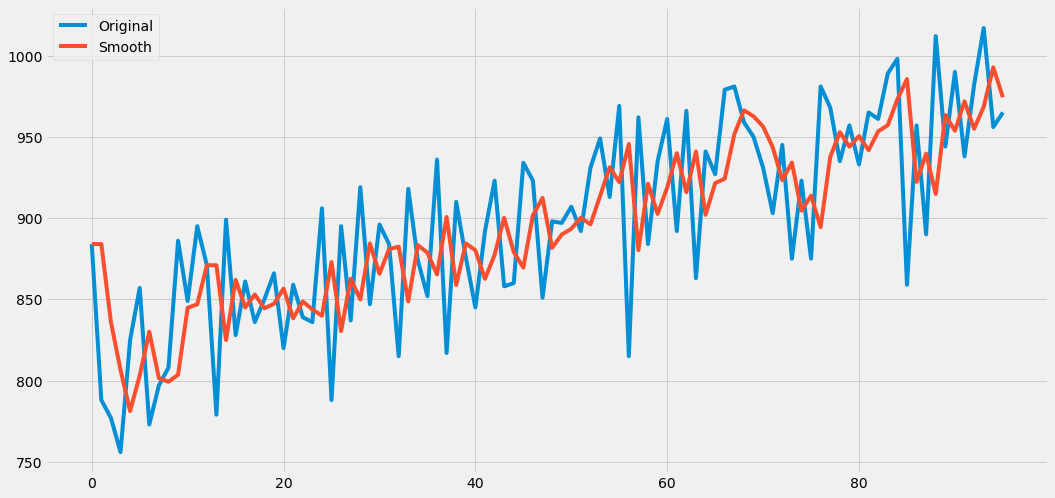

In [82]:
##smoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
plt.figure(figsize=(16,8))
plt.plot(dataset)
fit1 = SimpleExpSmoothing(dataset).fit(smoothing_level=0.5,optimized=False)
plt.plot(fit1.fittedvalues)
plt.legend(['Original', 'Smooth'])

In [84]:
df1 = pd.DataFrame(fit1.fittedvalues, columns= ['Fitted'])
df1.head()

,Fitted
0,884.000000
1,884.000002
2,874.400004
3,864.660009
4,853.794006


In [85]:
dataset = df1.values

In [86]:
training_data_len = math.ceil(len(dataset)*.875)
training_data_len

84

In [87]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [88]:
train_data = scaled_data[0:training_data_len,:]
look_backs = 11

x_train = []
y_train = []

for i in range(look_backs, len(train_data)):
    x_train.append(train_data[i-look_backs:i,0])
    y_train.append(train_data[i,0])
    if i<=look_backs+1:
        print(x_train)
        print(y_train)
        print()

[array([0.3948398 , 0.39483981, 0.3160305 , 0.2360719 , 0.14686957,
       0.12323169, 0.12822741, 0.06376539, 0.02545191, 0.        ,
       0.04112583])]
[0.04776466904687293]

[array([0.3948398 , 0.39483981, 0.3160305 , 0.2360719 , 0.14686957,
       0.12323169, 0.12822741, 0.06376539, 0.02545191, 0.        ,
       0.04112583]), array([0.39483981, 0.3160305 , 0.2360719 , 0.14686957, 0.12323169,
       0.12822741, 0.06376539, 0.02545191, 0.        , 0.04112583,
       0.04776467])]
[0.04776466904687293, 0.09150241821046912]



In [89]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(73, 11, 1)

In [138]:
model = Sequential() #initialize sequential model
model.add(LSTM(64,input_shape=(x_train.shape[1],1), return_sequences=True)) #LSTM layer with 32 neurons
model.add(LSTM(32, return_sequences=True)) #LSTM layer with 32 neurons
model.add(LSTM(32)) #LSTM layer with 32 neurons
model.add(Dense(16,activation='relu')) #Dense layer with 16 neurons
model.add(Dense(8,activation='relu')) #Dense layer with 8 neurons
model.add(Dense(1,activation='linear')) #Dense output layer with 1 neuron, linear activation

In [139]:
model.compile(loss='mse', optimizer='Adam', metrics=['mae'])

In [140]:
history = model.fit(x_train,y_train,epochs=5)

Epoch 1/5
3/3 [==============================] - 6s 10ms/step - loss: 0.2231 - mae: 0.3917
Epoch 2/5
3/3 [==============================] - 0s 12ms/step - loss: 0.1817 - mae: 0.3492
Epoch 3/5
3/3 [==============================] - 0s 11ms/step - loss: 0.1284 - mae: 0.2816
Epoch 4/5
3/3 [==============================] - 0s 12ms/step - loss: 0.0667 - mae: 0.2051
Epoch 5/5
3/3 [==============================] - 0s 14ms/step - loss: 0.0208 - mae: 0.1215


In [141]:
test_data = scaled_data[training_data_len - look_backs: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(look_backs, len(test_data)):
    x_test.append(test_data[i-look_backs:i, 0])

In [142]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [143]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [144]:
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.149400623272849

In [145]:
train = df1[:training_data_len]
valid = df1[training_data_len:]
valid['Predictions'] = predictions
valid

<ipython-input-145-f043aaa5b21f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


,Fitted,Predictions
84,943.794983,941.521057
85,949.215488,941.565002
86,940.193940,942.445312
87,941.874551,943.559204
88,936.687096,945.404907
89,944.218391,946.729614
90,944.196553,947.727112
91,948.776898,948.771484
92,947.699211,949.641724
93,951.129295,950.605164


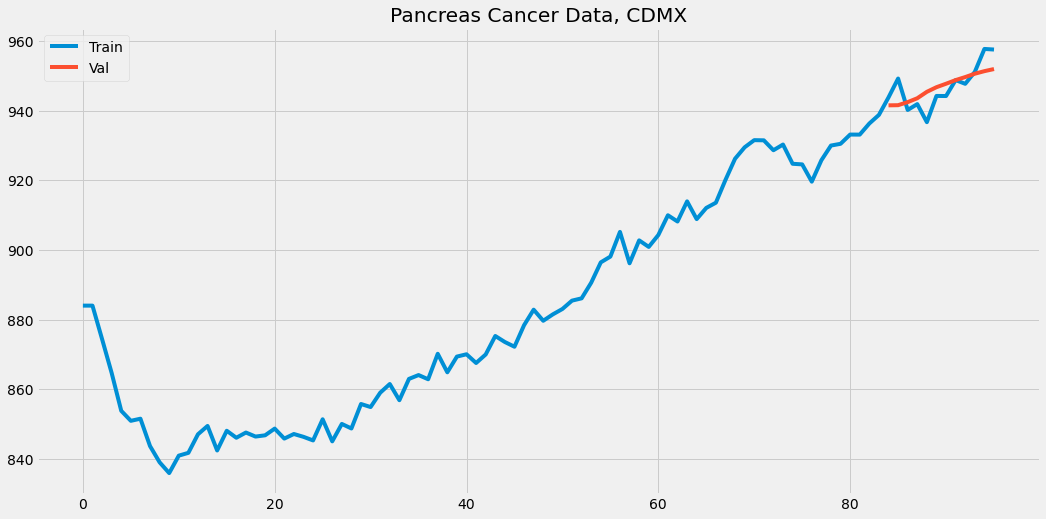

In [146]:
fig1 = plt.figure(figsize=(16,8))
plt.title("Pancreas Cancer Data, CDMX")
plt.plot(df1)
plt.plot(valid["Predictions"])
plt.legend(['Train', 'Val', 'Predictions'])
plt.show()

In [147]:
predictions = []
df1 = gdp_decomp.filter(['trend'])
for i in range (0,365):
    df1 = df1
    last_60_days = df1[-60+i:].values
    last_60_days_scaled = scaler.transform(last_60_days)
    X_test = []
    #Append the last 60 days
    X_test.append(last_60_days_scaled)
    #convert to a numpy array
    X_test = np.array(X_test)
    #reshape the data
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    #Get the predicted scaled value
    pred_val = model.predict(X_test)
    #undo the scaling
    pred_cases = scaler.inverse_transform(pred_val)
    predictions.append(pred_cases[0][0])
    df1 = df1.append({'trend': pred_cases[0][0]}, ignore_index=True)

In [ ]:
df1 = gdp_decomp[["trend"]]

for i in predictions:
    df1 = df1.append({'trend': i}, ignore_index=True)